# Model-Free Reinforcement Learning for Dynamic Asset Allocation

In [1]:
!pip install pandas matplotlib yfinance PyPortfolioOpt stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gym
  Running setup.py clean for gym
Failed to build gym
  Attempting uninstall: importlib-metadata
    Found e

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import time
import gym
from gym import spaces
from gym.utils import seeding
from stable_baselines3 import PPO, A2C, DDPG, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions

In [3]:
# Download ticker data

# ETFs that provide exposure to several asset classes and sectors
tickers = ["FCOM","FENY","FNCL","FHLC","FIDU","FMAT","FUTY","FTEC","FSTA"]

tickers_str = ""
for s in tickers:
  tickers_str += s + " "
#print(tickers_str)

data = []

yf.pdr_override()

data = yf.download(tickers_str, "2010-01-01", "2023-4-16")["Adj Close"]

[*********************100%***********************]  9 of 9 completed


In [4]:
#print(data.head(3))

# Define the training and test set
split_index = int(0.7 * len(data))
train_data = data[:split_index]
test_data =  data[split_index:]
print("Training data size: " + str(len(train_data)))
print(train_data.head(3))
print("\n")
print("Test data size: " + str(len(test_data)))
print(test_data.head(3))

Training data size: 1656
                 FCOM       FENY       FHLC       FIDU       FMAT       FNCL  \
Date                                                                           
2013-10-24  20.458694  18.064432  22.165133  22.006231  21.488832  20.599287   
2013-10-25  20.555773  18.115152  22.173927  22.075294  21.480322  20.648842   
2013-10-28  20.644758  18.144142  22.235500  22.083927  21.429274  20.657110   

                 FSTA       FTEC       FUTY  
Date                                         
2013-10-24  20.243248  22.761036  18.979244  
2013-10-25  20.259218  22.824610  19.174761  
2013-10-28  20.522848  22.842770  19.159719  


Test data size: 711
                 FCOM      FENY       FHLC       FIDU       FMAT       FNCL  \
Date                                                                          
2020-05-26  34.478180  9.237133  47.739506  33.578518  28.492767  30.902214   
2020-05-27  34.772202  9.335399  48.137337  34.718418  28.952478  32.287155   
2020-0

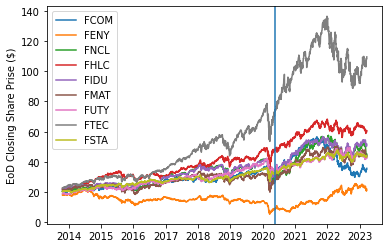

In [5]:
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.ylabel("EoD Closing Share Prise ($)")
plt.axvline(pd.to_datetime("2020-05-21"))
plt.legend()

In [ ]:
# Split the data by the frequency we want to be able to take steps, i.e. how often we want to be able to rebalance (1 index)
step_freq = 1
parsed_training = train_data[::step_freq]
parsed_test = test_data[::step_freq]

In [ ]:
iterations = 15
timesteps = 20000
length = parsed_test.shape[0]
stocks = parsed_test.shape[1]
init_bal = 1000000 # Initial account balance
trade_commission = 0.001 # Transaction fee TODO: was 0.01
min_trade_share_size = 10 # The minimum amount of shares per trade

class AssetAllocationEnv(gym.Env):

    def __init__(self,
                 dataframe,
                 index = 0 # Current day index
                 ):
        
        self.dataframe = dataframe
        self.num_assets = self.dataframe.shape[1]
        self.index = index
        self.action_space = spaces.Box(low = -1, high = 1, shape = (self.num_assets,)) # as defined in the slides: can choose to allocate into n assets 
        self.state_space = spaces.Box(low=0, high=np.inf, shape = (2*self.num_assets+1,)) # as defined in the slides: # of shares owned + the current bal + price
        
       
        self.data = self.dataframe.iloc[self.index]
        self.terminal = False
        
        self.state = [init_bal] + self.data.values.tolist() + ([0] * self.num_assets)
        
        self.reward = 0

        self.asset_memory = [init_bal]
        self.memory=[ [1 / self.num_assets] * self.num_assets ]
        
        self._seed(0) 

    def sell(self, index, action):
        action = math.floor(action)
        if self.state[index + 1 + self.num_assets] > 0:
            self.state[index + 1 + self.num_assets] = self.state[index + 1 + self.num_assets] - min(self.state[index + 1 + self.num_assets], abs(action))
            self.state[0] = self.state[0] + self.state[index + 1] * (1 - trade_commission) * min(self.state[index + 1 + self.num_assets], abs(action))
    
    def buy(self, index, action):
        action = math.floor(action)
        self.state[index + 1 + self.num_assets] = self.state[index + 1 + self.num_assets] + action
        self.state[0] = self.state[0] - self.state[index + 1] * (trade_commission + 1) * action
        
    def step(self, actions):
        self.terminal = len(self.dataframe.index.unique()) <= self.index + 1

        if self.terminal == False:
            total =  sum(np.array(self.state[1:self.num_assets + 1])*np.array(self.state[(self.num_assets+1):(self.num_assets*2+1)])) + self.state[0]
            
            actions *= min_trade_share_size
            sorted = np.argsort(actions)
            for i in sorted[::-1][:np.where(actions > 0)[0].shape[0]]:
                self.buy(i, actions[i])

            for i in sorted[:np.where(actions < 0)[0].shape[0]]:
                self.sell(i, actions[i])
        
            self.index += 1
            self.data = self.dataframe.iloc[self.index,:]
            self.state =  [self.state[0]] + self.data.values.tolist() + list(self.state[(self.num_assets+1):(self.num_assets * 2 + 1)])
            self.reward = self.state[0] + sum(np.array(self.state[1:(self.num_assets + 1)]) * np.array(self.state[(self.num_assets + 1):(self.num_assets*2 + 1)])) - total            
            self.memory.append(self.normalize(np.array(self.state[(self.num_assets+1):(self.num_assets*2+1)])).tolist())
        
        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.terminal = False 
        self.index = 0
        self.memory=[[1 / self.num_assets]*self.num_assets]
        self.state = [init_bal] + self.data.values.tolist() + ([0]*self.num_assets)
        self.data = self.dataframe.iloc[self.index,:]
        self._seed(0)
        return self.state
    
    def normalize(self, actions):
        return actions / (sum(actions) + 1e-16)

    def render(self, mode='human',close=False):
        return self.state

    def memory(self):
        return self.memory
    
    # for deterministic results
    def _seed(self, seed = None):
        return [seeding.np_random(seed)]

In [ ]:
p = "MlpPolicy"
def train(m, env, timesteps, seed = None): 
    if m == "PPO":
        model = PPO(p, env, verbose = 0, seed = seed)
    if m == "A2C":
        model = A2C(p, env, verbose = 0, seed = seed)
    if m == "SAC":
        model = SAC(p, env, verbose = 0, seed = seed)  
    if m == "DDPG":
        model = DDPG(p, env, verbose = 0, seed = seed)
        
    model.learn(total_timesteps=timesteps)
    return model

In [ ]:
def predict(model, data, env, oenv):
    memory = []
    model.set_random_seed(0)

    for i, val in enumerate(data.index.unique()):
        action, _ = model.predict(oenv)
        oenv, r, term, info = env.step(action)
        if len(data.index.unique()) == i + 2 :
            memory = env.env_method(method_name="memory")

    return memory[0]

In [ ]:
returns = np.zeros([iterations, length])
portfolio = np.zeros([iterations, length, stocks])

m = "A2C"

i=0
while i < iterations:

    model = train(m, p, DummyVecEnv([lambda: AssetAllocationEnv(dataframe = parsed_training)]), timesteps, seed = 0, save=False)

    test_env = DummyVecEnv([lambda: AssetAllocationEnv(data = parsed_test)]).reset()
    reset_env = test_env.reset()

    portfolio[i] = np.array(predict(model, parsed_test, test_env, reset_env))

    indv_returns = np.sum(parsed_test.pct_change().multiply(portfolio[i]),axis=1)
    returns[i] = (indv_returns + 1).cumprod()

    i += 1

Training time:  0.32200249830881755  minutes
Training time:  0.30887755552927654  minutes
Training time:  0.32080317735672  minutes
Training time:  0.3103336532910665  minutes
Training time:  0.3033646543820699  minutes


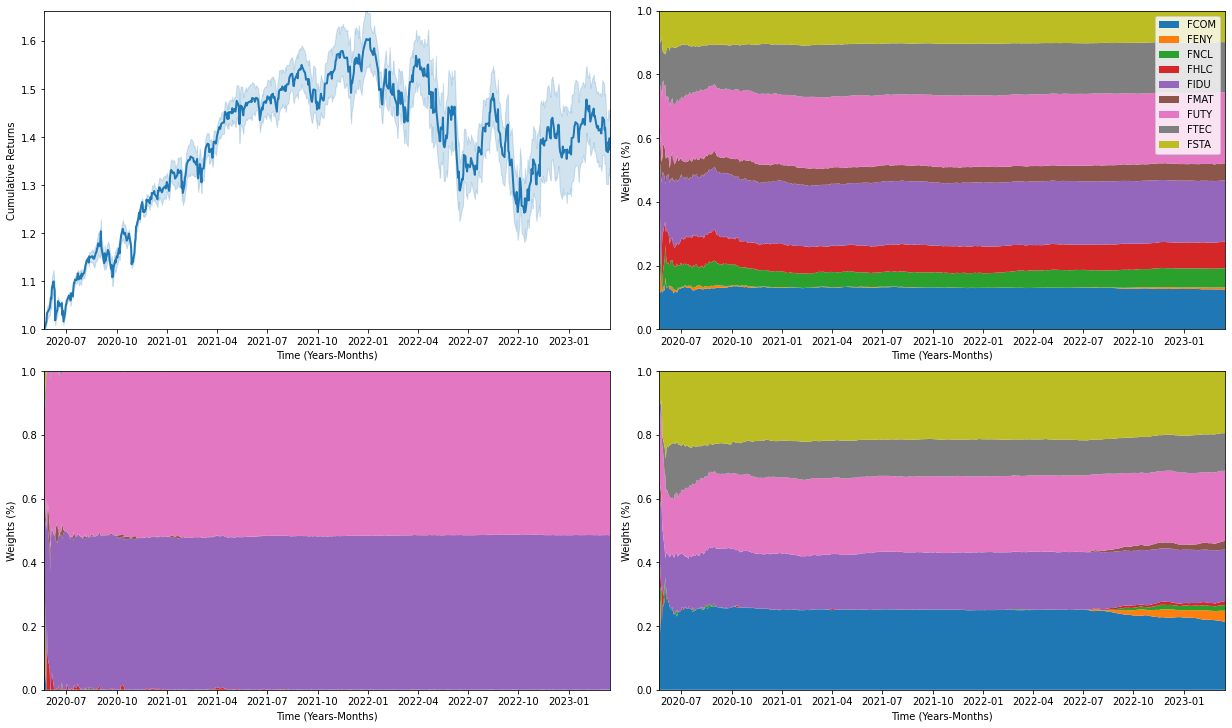

In [ ]:
mean = np.mean(np.array(returns),axis=0)
std = np.std(np.array(returns),axis=0)

plt.plot(parsed_test.index, mean, color='tab:blue')
plt.fill_between(parsed_test.index, mean - std, mean + std, alpha=0.2, color='tab:blue')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Cumulative Returns")
plt.set_xlabel("Time")
plt.show()

portfolio_ = np.mean(np.array(portfolio),axis=0)
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmax(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmin(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

In [ ]:
returns = np.zeros([iterations, length])
portfolio = np.zeros([iterations, length, stocks])

m = "SAC"

i=0
while i < iterations:

    model = train(m, p, DummyVecEnv([lambda: AssetAllocationEnv(dataframe = parsed_training)]), timesteps, seed = 0, save=False)

    test_env = DummyVecEnv([lambda: AssetAllocationEnv(data = parsed_test)]).reset()
    reset_env = test_env.reset()

    portfolio[i] = np.array(predict(model, parsed_test, test_env, reset_env))

    indv_returns = np.sum(parsed_test.pct_change().multiply(portfolio[i]),axis=1)
    returns[i] = (indv_returns + 1).cumprod()

    i += 1

Training time:  4.82115124464035  minutes
Training time:  4.747572902838389  minutes
Training time:  4.661180877685547  minutes
Training time:  4.751258011658987  minutes
Training time:  4.810598723093668  minutes


Text(0.5, 0, 'Time (Years-Months)')

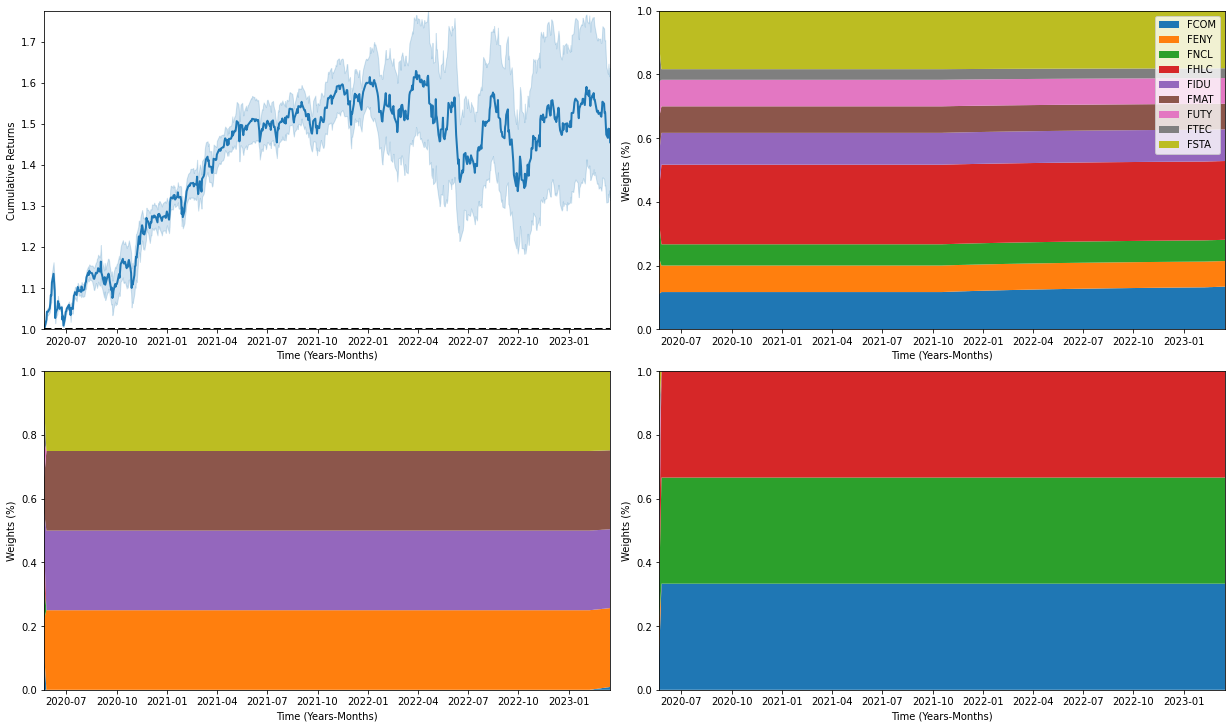

In [ ]:
mean = np.mean(np.array(returns),axis=0)
std = np.std(np.array(returns),axis=0)

plt.plot(parsed_test.index, mean, color='tab:blue')
plt.fill_between(parsed_test.index, mean - std, mean + std, alpha=0.2, color='tab:blue')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Cumulative Returns")
plt.set_xlabel("Time")
plt.show()

portfolio_ = np.mean(np.array(portfolio),axis=0)
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmax(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmin(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

In [ ]:
returns = np.zeros([iterations, length])
portfolio = np.zeros([iterations, length, stocks])

m = "PPO"

i=0
while i < iterations:

    model = train(m, p, DummyVecEnv([lambda: AssetAllocationEnv(dataframe = parsed_training)]), timesteps, seed = 0, save=False)

    test_env = DummyVecEnv([lambda: AssetAllocationEnv(data = parsed_test)]).reset()
    reset_env = test_env.reset()

    portfolio[i] = np.array(predict(model, parsed_test, test_env, reset_env))

    indv_returns = np.sum(parsed_test.pct_change().multiply(portfolio[i]),axis=1)
    returns[i] = (indv_returns + 1).cumprod()

    i += 1

Training time:  0.2727387030919393  minutes
Training time:  0.2818402647972107  minutes
Training time:  0.26951639652252196  minutes
Training time:  0.27100520928700766  minutes
Training time:  0.28003199100494386  minutes


Text(0.5, 0, 'Time (Years-Months)')

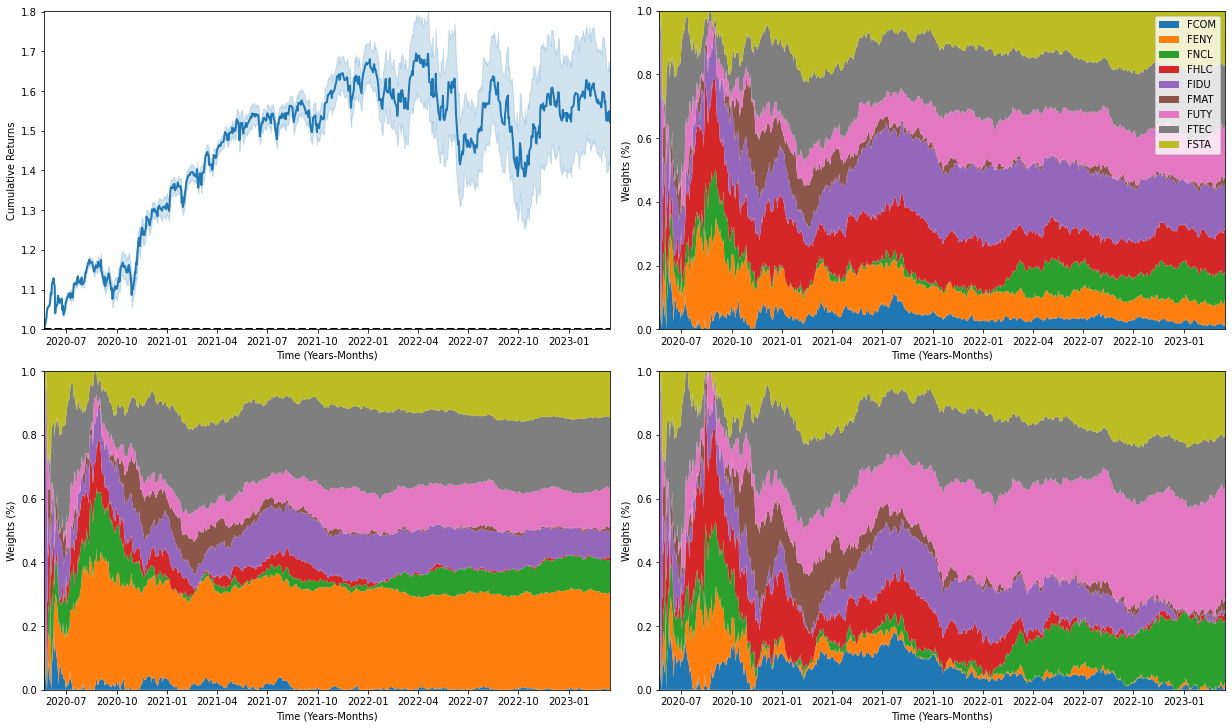

In [ ]:
mean = np.mean(np.array(returns),axis=0)
std = np.std(np.array(returns),axis=0)

plt.plot(parsed_test.index, mean, color='tab:blue')
plt.fill_between(parsed_test.index, mean - std, mean + std, alpha=0.2, color='tab:blue')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Cumulative Returns")
plt.set_xlabel("Time")
plt.show()

portfolio_ = np.mean(np.array(portfolio),axis=0)
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmax(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmin(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

In [ ]:
returns = np.zeros([iterations, length])
portfolio = np.zeros([iterations, length, stocks])

m = "DDPG"

i=0
while i < iterations:

    model = train(m, p, DummyVecEnv([lambda: AssetAllocationEnv(dataframe = parsed_training)]), timesteps, seed = 0, save=False)

    test_env = DummyVecEnv([lambda: AssetAllocationEnv(data = parsed_test)]).reset()
    reset_env = test_env.reset()

    portfolio[i] = np.array(predict(model, parsed_test, test_env, reset_env))

    indv_returns = np.sum(parsed_test.pct_change().multiply(portfolio[i]),axis=1)
    returns[i] = (indv_returns + 1).cumprod()

    i += 1

Training time:  3.3361398140589396  minutes
Training time:  3.3727949500083922  minutes
Training time:  3.4021660725275678  minutes
Training time:  3.4005404035250346  minutes
Training time:  3.4489150802294413  minutes
Training time:  3.4241241534550984  minutes
Training time:  3.4770648161570232  minutes


Text(0.5, 0, 'Time (Years-Months)')

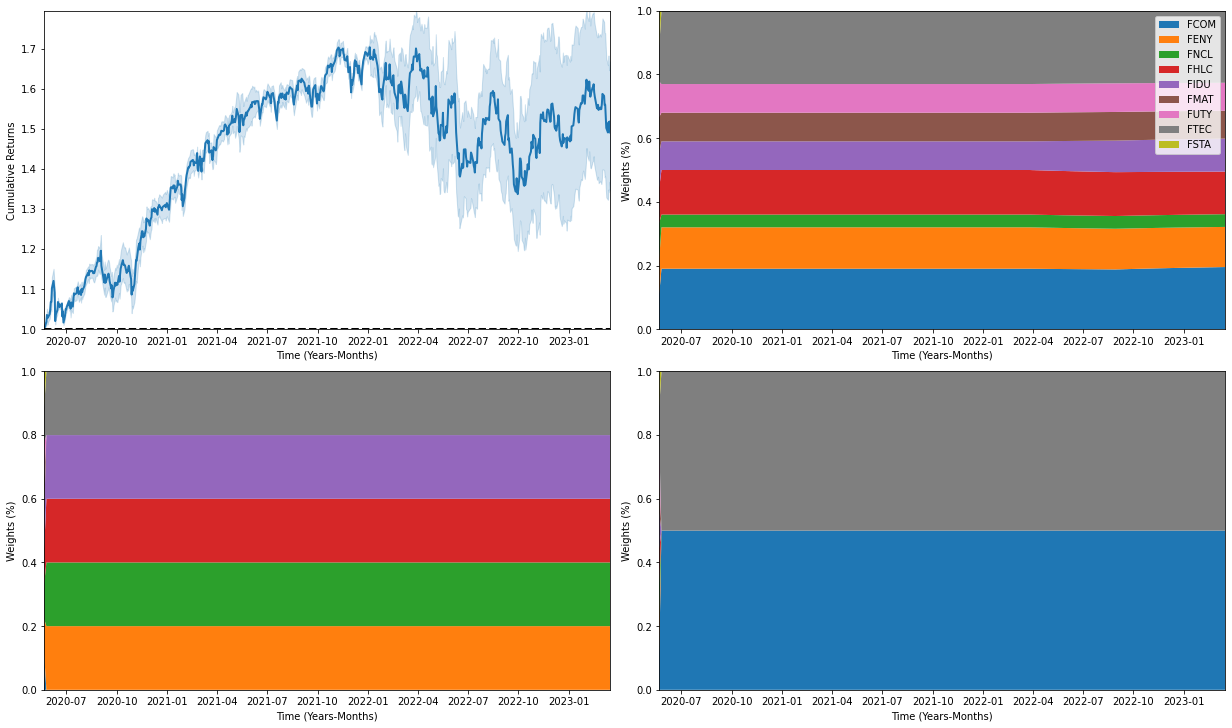

In [ ]:
mean = np.mean(np.array(returns),axis=0)
std = np.std(np.array(returns),axis=0)

plt.plot(parsed_test.index, mean, color='tab:blue')
plt.fill_between(parsed_test.index, mean - std, mean + std, alpha=0.2, color='tab:blue')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Cumulative Returns")
plt.set_xlabel("Time")
plt.show()

portfolio_ = np.mean(np.array(portfolio),axis=0)
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmax(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

portfolio_ = portfolio[np.argmin(returns[:,-1])]
data = pd.DataFrame(portfolio_, index = parsed_test.index, columns = tickers)
plt.stackplot(parsed_test.index, data["FCOM"], data["FENY"], data["FNCL"], data["FHLC"], data["FIDU"], data["FMAT"], data["FUTY"], data["FTEC"], data["FSTA"], labels=tickers)
plt.margins(x=0)
plt.margins(y=0)
plt.set_ylabel("Weights (%)")
plt.set_xlabel("Time")
plt.show()

In [ ]:
# Traditional methods
window = 50
start = len(train_data)-window
data = re_df.iloc[start:]
data = data.reset_index(drop=True)

In [ ]:
# min- var
portfolio_weights_min_var = np.zeros([test_data.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_var.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    ef = EfficientFrontier(mu, S)
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_min_var[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Text(0.5, 0, 'Time (Years-Months)')

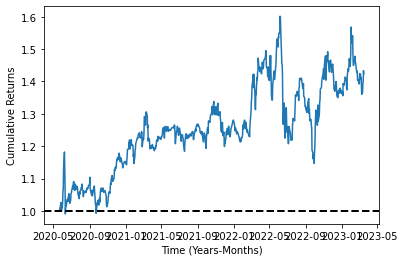

In [ ]:
return_stocks = test_data.pct_change()
return_stocks_min_var = np.sum(return_stocks.multiply(portfolio_weights_min_var),axis=1)
returns_daily_min_var = (1+return_stocks_min_var).cumprod()
plt.plot(returns_daily_min_var)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time")


Text(0.5, 0, 'Time (Years-Months)')

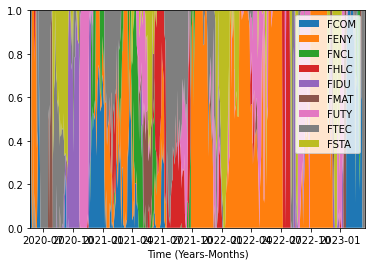

In [ ]:
df = pd.DataFrame (portfolio_weights_min_var, index = test_data.index, columns = tickers)
plt.stackplot(test_data.index, df["FCOM"], df["FENY"], df["FNCL"], df["FHLC"], df["FIDU"], df["FMAT"], df["FUTY"], df["FTEC"], df["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time")

In [ ]:
# min vol
portfolio_weights_min_vol = np.zeros([test_data.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_vol.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    weights = EfficientFrontier(mu, S)  .min_volatility() 
   
    portfolio_weights_min_vol[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Text(0.5, 0, 'Time (Years-Months)')

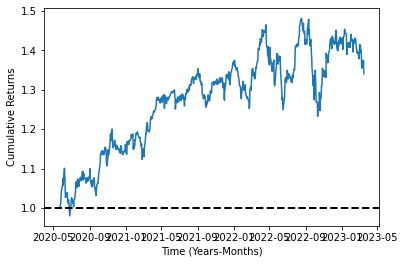

In [ ]:
return_stocks_min_vol = np.sum(return_stocks.multiply(portfolio_weights_min_vol),axis=1)
returns_daily_min_vol = (1+return_stocks_min_vol).cumprod()
plt.plot(returns_daily_min_vol)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time")

Text(0.5, 0, 'Time (Years-Months)')

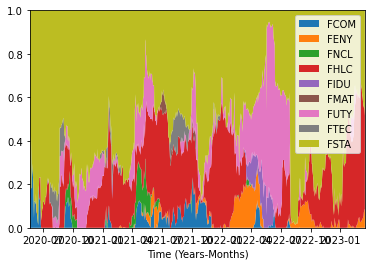

In [ ]:
df = pd.DataFrame (portfolio_weights_min_vol, index = test_data.index, columns = tickers)
plt.stackplot(test_data.index, df["FCOM"], df["FENY"], df["FNCL"], df["FHLC"], df["FIDU"], df["FMAT"], df["FUTY"], df["FTEC"], df["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time")

In [ ]:
portfolio_weights_equal = np.ones([test_data.shape[0],test_data.shape[1]])/test_data.shape[1]

Text(0.5, 0, 'Time (Years-Months)')

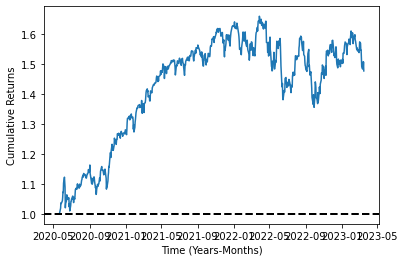

In [ ]:
return_stocks = test_data.pct_change()
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
returns_daily_equal = (1+return_stocks_equal).cumprod()
plt.plot(returns_daily_equal)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time")

Text(0.5, 0, 'Time (Years-Months)')

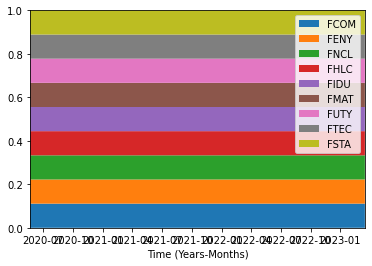

In [ ]:
df = pd.DataFrame (portfolio_weights_equal, index = test_data.index, columns = tickers)
plt.stackplot(test_data.index, df["FCOM"], df["FENY"], df["FNCL"], df["FHLC"], df["FIDU"], df["FMAT"], df["FUTY"], df["FTEC"], df["FSTA"], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time")

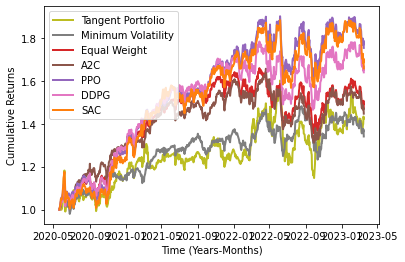

In [ ]:
x = returns_daily_equal.index.values

plt.plot(x, returns_daily_min_var, label="Tangency Portfolio")
plt.plot(x, returns_daily_min_vol, label="Minimum Volatility")
plt.plot(x, returns_daily_equal, label="Equal Weights")

a2c = returns_a2c[np.argmax(returns_a2c[:,-1])]
plt.plot(x, a2c, label='A2C')
sac = returns_sac[np.argmax(returns_sac[:,-1])]
plt.plot(x, sac, label='SAC')
ppo = returns_ppo[np.argmax(returns_ppo[:,-1])]
plt.plot(x, ppo, label='PPO')
ddpg = returns_ddpg[np.argmax(returns_ddpg[:,-1])]
plt.plot(x, ddpg, label='DDPG')

plt.ylabel("Cumulative Returns")
plt.xlabel("Time")
plt.legend()
plt.show()